In [1]:
from sqlalchemy import create_engine
from sqlalchemy.inspection import inspect
from declare_db import Base, Info, Item
from sqlalchemy.orm import sessionmaker
from collections import defaultdict
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
db_name = "exchange.db"
engine_name = 'sqlite:///exchange.db'

def query_to_dict(rset):
    result = defaultdict(list)
    for obj in rset:
        instance = inspect(obj)
        for key, x in instance.attrs.items():
            result[key].append(x.value)
    return result

In [3]:
engine = create_engine(engine_name)
Base.metadata.bind = engine

DBSession = sessionmaker(bind=engine)
session = DBSession()

In [4]:
mats = session.query(Info).join(Item, Info.item_name==Item.info_name).filter(Item.item_type=='Mat').all()

In [5]:
df = pd.DataFrame(query_to_dict(mats)).set_index('id')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

In [6]:
mat_prices = df['price'].groupby(df['item_name']).mean().astype('int64').rename('avg_price')

In [7]:
df = df.join(mat_prices, on='item_name')

In [8]:
df.head(5)

,item_name,timestamp,price,volume,datetime,avg_price
id,,,,,,
21,crystal_mirror,1547025711,131659,19115,2019-01-09 09:21:51,196560
20,crystal_mirror,1547049276,143245,451,2019-01-09 15:54:36,196560
19,crystal_mirror,1547094729,173327,706,2019-01-10 04:32:09,196560
18,crystal_mirror,1547116614,190660,71,2019-01-10 10:36:54,196560
17,crystal_mirror,1547143414,209612,7128,2019-01-10 18:03:34,196560


In [9]:
df['avg_price'].unique()

array([ 196560,  128536,  124409,  174565,  180802,  205250,  222784,
        225553,   98644,  182552,  120134,  173189,  114415,  178578,
         88209,  160562,  199222,  286322,   53483,   25559,    1467,
          2556,  579986, 1297775, 1030837,   13629])

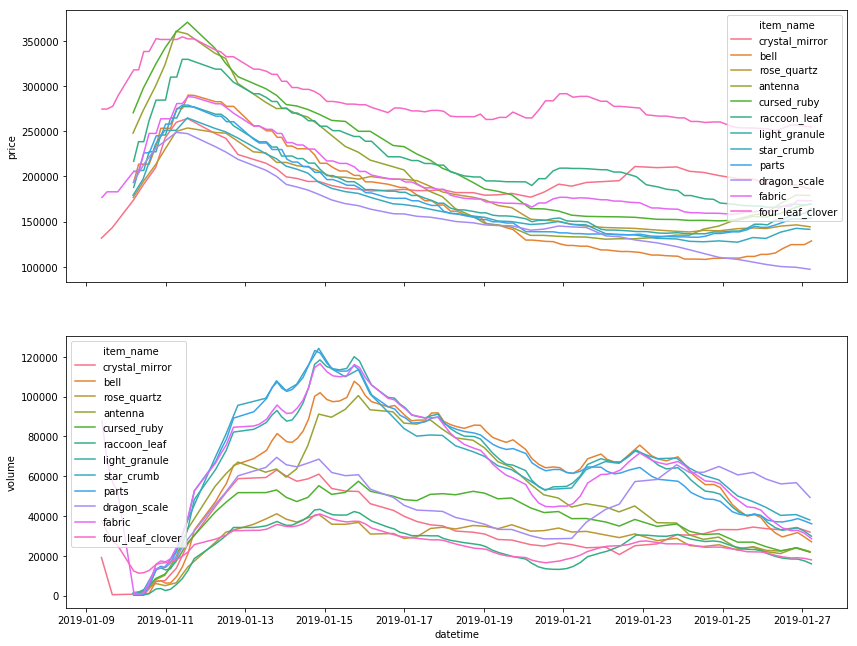

In [10]:
high_mats = df[(df['avg_price'] > 150000) & (df['avg_price'] < 400000) & (df['price'] < 1200000)]
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(14,11))
sns.lineplot(data=high_mats[['item_name', 'price', 'datetime']], x='datetime', y='price', hue='item_name', ax=ax1)
sns.lineplot(data=high_mats[['item_name', 'volume', 'datetime']], x='datetime', y='volume', hue='item_name', ax=ax2)
plt.show()

In [11]:
def process_df(df):
    processed = df.copy()
    processed = processed.set_index('id')
    processed['datetime'] = pd.to_datetime(processed['timestamp'], unit='s')
    avg_prices = processed.groupby(['item_name'])['price'].mean().astype('int64').rename('avg_price')
    processed = processed.join(avg_prices, on='item_name')
    processed['date'] = processed['datetime'].dt.date
    processed = processed.groupby(['item_name', 'date'])['price', 'volume', 'avg_price'].mean().astype('int64')
    return processed

In [12]:
matsdf = pd.DataFrame(query_to_dict(mats))
df = process_df(matsdf).reset_index()

In [13]:
ant = df[df['item_name']=='antenna']
pearl = df[df['item_name']=='pearl']
print(ant.tail(5))
print(pearl.tail(5))

   item_name        date   price  volume  avg_price
13   antenna  2019-01-23  133728   36537     205250
14   antenna  2019-01-24  140418   29363     205250
15   antenna  2019-01-25  155026   24020     205250
16   antenna  2019-01-26  169545   22432     205250
17   antenna  2019-01-27  178765   22146     205250
    item_name        date  price  volume  avg_price
337     pearl  2019-01-23  93559   55403     114415
338     pearl  2019-01-24  93772   58568     114415
339     pearl  2019-01-25  93649   57554     114415
340     pearl  2019-01-26  94825   54145     114415
341     pearl  2019-01-27  94845   52057     114415


In [14]:
df['item_name'].unique()

array(['antenna', 'bell', 'biotite', 'bloody_rune', 'coal',
       'crystal_mirror', 'cursed_ruby', 'dragon_scale', 'emperium',
       'fabric', 'four_leaf_clover', 'frozen_rose', 'heroic_emblem',
       'key_of_clock_tower', 'light_granule', 'mercury', 'orc_claw',
       'parts', 'pearl', 'raccoon_leaf', 'rose_quartz', 'soft_feather',
       'star_crumb', 'steel', 'time_twister', 'wrapping_lace'],
      dtype=object)

In [15]:
def plot_stats(data):
    fig, ax1 = plt.subplots(figsize=(8, 6))
    plt.xticks(rotation=45)
    ax2 = ax1.twinx()
    ax1.bar(data['date'].apply(mdates.date2num), data['volume'], color=(190/255,190/255,190/255,0.7), label='Volume')
    ax2.plot(data['date'].apply(mdates.date2num), data['price'], label='Price')

    # handle the legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    # Fix the date format on x-axis
    myFmt = mdates.DateFormatter('%Y-%m-%d')
    ax1.xaxis.set_major_formatter(myFmt)
    
    # Align the 2 y-axis
    ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))
    ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))

    # bells and whistles
    ax1.set_title(data.iloc[0]['item_name'])
    ax1.set_ylabel('Volume')
    ax2.set_ylabel('Price')
    ax1.grid(True)

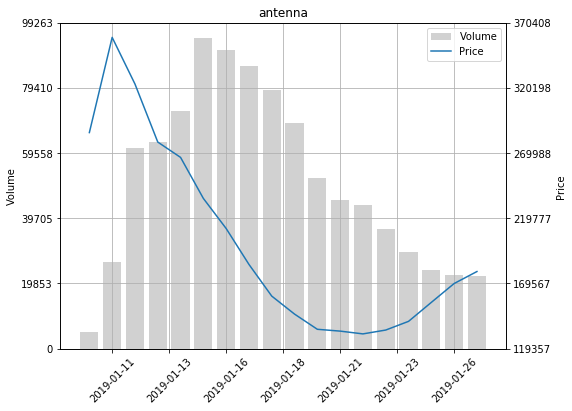

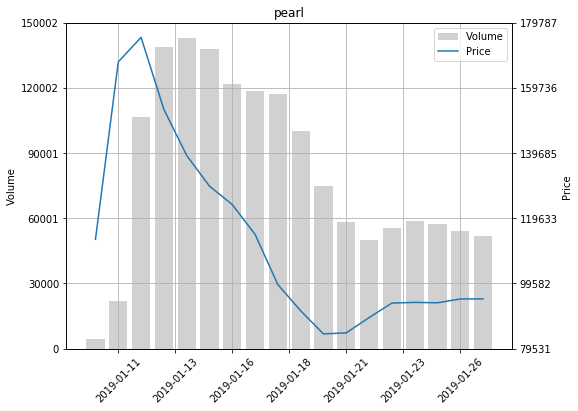

In [16]:
mats = [ant, pearl]
for mat in mats:
    plot_stats(mat)

'''
for i in plt.get_fignums():
    plt.figure(i)
    plt.savefig('figure%d.png' % i)
'''

plt.show()

In [22]:
cards = session.query(Info).join(Item, Info.item_name==Item.info_name).filter(Item.item_type=='Card').all()
df = pd.DataFrame(query_to_dict(cards))
df = process_df(df).reset_index()

In [36]:
slots = [x[0] for x in session.query(Item.slot).filter(Item.item_type=='Card').distinct().all()]
for slot in slots:
    print(slot)
    c = (session.query(Info).join(Item, Info.item_name==Item.info_name)
             .filter(Item.item_type=='Card')
             .filter(Item.slot==slot).all())
    df = pd.DataFrame(query_to_dict(c))
    df = process_df(df).reset_index()
    print(df.head(5))

Accessory
     item_name        date    price  volume  avg_price
0  creamy_card  2019-01-10  1298932      56    1115515
1  creamy_card  2019-01-11  1256571      69    1115515
2  creamy_card  2019-01-12  1173081       6    1115515
3  creamy_card  2019-01-13  1248481      73    1115515
4  creamy_card  2019-01-14  1110089     108    1115515
Armor
            item_name        date   price  volume  avg_price
0  ancient_clock_card  2019-01-10  630644     433     505598
1  ancient_clock_card  2019-01-11  585067     371     505598
2  ancient_clock_card  2019-01-12  550692     199     505598
3  ancient_clock_card  2019-01-13  514875     467     505598
4  ancient_clock_card  2019-01-14  508542     195     505598
Weapon
             item_name        date     price  volume  avg_price
0  abysmal_knight_card  2019-01-10  13055397      17   17119810
1  abysmal_knight_card  2019-01-11  19368255      25   17119810
2  abysmal_knight_card  2019-01-12  17536475      16   17119810
3  abysmal_knight_card  2